<a href="https://colab.research.google.com/github/abhilasha-kumar/modeling-lexical-retrieval/blob/main/LexicalRetrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Access and import Drive folder

First, we connect to Google Drive and import the necessary files in this [public folder](https://drive.google.com/drive/folders/1lvklXvUAg44OgRXKy1qryPVjcQElNIYi?usp=sharing).

In [1]:
from google.colab import auth
auth.authenticate_user()  # must authenticate

'''list all ids of files directly under folder folder_id'''
def folder_list(folder_id):
  from googleapiclient.discovery import build
  gdrive = build('drive', 'v3').files()
  res = gdrive.list(q="'%s' in parents" % folder_id).execute()
  return [f['id'] for f in res['files']]

'''download all files from a gdrive folder to current directory'''
def folder_download(folder_id):
  for fid in folder_list(folder_id):
    !gdown -q --id $fid


In [2]:
# this is the folder ID for our public Drive. downloading may take a moment.
folder_download('1lvklXvUAg44OgRXKy1qryPVjcQElNIYi')

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in

# GPU access

In [3]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Found GPU at: /device:GPU:0
Mon Mar  6 18:27:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    31W /  70W |    333MiB / 15360MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+-------------

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import heapq
import itertools
import scipy.spatial.distance

import pandas as pd
import numpy as np

from numpy.random import randint
from scipy.special import softmax
from sklearn.preprocessing import MinMaxScaler, normalize
from numpy.linalg import matrix_power
from functools import lru_cache
import glob
from scipy.special import expit
from scipy import stats

import matplotlib.pyplot as plt
import nltk
from functools import lru_cache
from itertools import product as iterprod
import itertools
from nltk.metrics import *
import re
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Importing Data

We read in the experimental data and vocabulary words.

In [5]:
with tf.device('/device:GPU:0'):
  julie_files = pd.read_csv("Julie_2021data.csv", encoding= 'unicode_escape')
  orig_vocab = pd.read_csv("julie_vocab.csv")
  vocab_plus = pd.read_csv("full_vocab.csv")

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (23) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Import USE

The Universal Sentence Encoder uses two different architctures to encode a string of any length into a compact high-dimensional vector representation -- the Deep Averaging Network (which is more of a bag-of-words approach) and the Transformer network (more predictive, attention-based).  

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
dan_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
#transformer_url = "https://tfhub.dev/google/universal-sentence-encoder-large/5" 
model = hub.load(dan_url)
print ("module %s loaded" % dan_url)

In [8]:
# cosine similarity function
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

# Create phoneme function

Here we create a function that takes any letter string and partitions it into phonemes based on arpabet. Then we compute a measure of "normalized" phonemic similarity

In [67]:
# algo to obtain phonemes for any given strng
# obtained from: https://stackoverflow.com/questions/33666557/get-phonemes-from-any-word-in-python-nltk-or-other-modules
try:
    arpabet = nltk.corpus.cmudict.dict()
except LookupError:
    nltk.download('cmudict')
    arpabet = nltk.corpus.cmudict.dict()

@lru_cache()
def wordbreak(s):
    s = s.lower()
    s = re.sub('[^a-zA-Z]+', '', s)
    if s in arpabet:
        return arpabet[s]
    middle = len(s)/2
    partition = sorted(list(range(len(s))), key=lambda x: (x-middle)**2-x)
    for i in partition:
        pre, suf = (s[:i], s[i:])
        if pre in arpabet and wordbreak(suf) is not None:
            return [x+y for x,y in iterprod(arpabet[pre], wordbreak(suf))]
    return None

def normalized_sim(w1, w2):
  return 1-edit_distance(w1,w2)/(max(len(w1), len(w2)))

# preparing/reducing data size

Creating reduced data set with only unique prompts and primes

In [ ]:
## preparing data
julie_files["ActualPrime"] = np.where(julie_files['PrimeCondition'] == 'P', julie_files['Phonological'], 
                                      np.where(julie_files['PrimeCondition'] == 'B', julie_files['Both'], 
                                               np.where(julie_files['PrimeCondition'] == 'R', julie_files['Semantic'],julie_files['Neither']))) 
julie_files['prompt'] = julie_files['prompt'].str.replace('\t',' ')                                      
julie_files['prompt'] = julie_files['prompt'].str.strip()
print(f"full dataset is {len(julie_files)} rows")
## for target accuracy we only need 100 (prompts) x 4 (primes)
targetacc_data = julie_files[["ActualPrime", "PrimeCondition", "Target", "prompt"]].drop_duplicates()

print(f"target accuracy data is {len(targetacc_data)} rows")


full dataset is 17400 rows
target accuracy data is 400 rows


# Computing all vectors

Only necessary to complete once, or can otherwise move to the next cell and read in the already computed vectors

In [ ]:
# pre-computing all vectors for prompts and vocabulary words 
# takes in dataframe containing prompts, creates dataframes of prompt and vocab vectors, exports them to Drive
def vectors(data):
  prompts = pd.Series(data["prompt"].unique())
  p_vecs = np.array([model([x])[0].numpy() for x in prompts])
  print(p_vecs.shape)

  p_vectors_df = pd.DataFrame(p_vecs).transpose()
  print(p_vectors_df.shape)
  p_vectors_df.columns = prompts
  print(p_vectors_df.head())
  p_vectors_df.to_csv("PromptVectors_New.csv", index = False)

  words = list(orig_vocab.vocab_word) + list(vocab_plus.vocab_word[12618:]) # original vocab list + all added words from responses
  w_vecs = np.array([model([x])[0].numpy() for x in words])
  print(w_vecs.shape)
  w_vectors_df = pd.DataFrame(w_vecs).transpose()

  print(w_vectors_df.shape)
  w_vectors_df.columns = words
  print(w_vectors_df.head())
  w_vectors_df.to_csv("VocabVectors_New.csv", index = False)

vectors(targetacc_data)


(100, 512)
(512, 100)
   To refrain deliberately and often with an effort of self-denial from an action or practice  ...  Happening by a lucky chance or by accident rather than by design
0                                           0.014262                                           ...                                          -0.002915               
1                                           0.018321                                           ...                                          -0.052756               
2                                           0.026393                                           ...                                          -0.002790               
3                                          -0.029389                                           ...                                           0.019612               
4                                           0.018353                                           ...                                           0.037026    

In [10]:
# read and store precomputed vectors, verify that they have the expected dimensions
prompt_vectors = pd.read_csv("PromptVectors_New.csv")
print(prompt_vectors.shape)
vocab_vectors = pd.read_csv("VocabVectors_New.csv")
print(vocab_vectors.shape)

(512, 100)
(512, 13693)


In [ ]:
# each prompt/vocabulary word is represented by a 512-dimensional vector
prompt_vectors['Capital of South Korea']

0      0.018930
1     -0.011326
2      0.000773
3      0.041382
4     -0.006024
         ...   
507   -0.052603
508    0.031974
509   -0.059387
510   -0.077468
511   -0.072401
Name: Capital of South Korea, Length: 512, dtype: float64

# Model functions

In [11]:
def initial_activation(vocab_words):
  # returns an array of initial activations, currently zero, but eventually replace by word frequency
  x = np.zeros((len(vocab_words),1)).T
  return x

In [12]:
def activate_prompt_neighbors(activations, prompt, noise_level):
  ## takes in a 1-d array of current activations
  ## computes a vector representation of the prompt and returns a vector of similarities to each word in vocab + activations
  ## with some noise added to each estimate
  noise = np.random.normal(0, noise_level, 1)
  prompt_vec = prompt_vectors[prompt].values
  resp = vocab_vectors.columns
  cosine_list = np.array([cosine(prompt_vec, vocab_vectors[r].values) for r in resp]) + activations # eventually add noise
  return cosine_list


In [69]:
def activate_prime_neighbors(prime):
  ## returns "primed" activations for both semantic and phonological 
  prime_vec = vocab_vectors[prime].values
  resp = vocab_vectors.columns
  semantic = np.array([cosine(prime_vec, vocab_vectors[r].values) for r in resp])
  phon = np.array([normalized_sim(wordbreak(r)[0], wordbreak(prime)[0]) for r in resp]).reshape(semantic.shape)
  assert semantic.shape == phon.shape
  return semantic, phon


In [14]:
def combine_semantic_phonological(prompt_act, semantic, phonological, theta=0): 
  # takes in activation arrays for prompt, prime-semantic, and prime phonological and combine with specified operation
  # returns softmax of combined activations
  if theta <= 1:
    wtds = theta * semantic
    wtdp = (1-theta)*phonological
    comb = np.add(wtds, wtdp) + prompt_act
  else:
    comb = np.multiply(semantic, phonological) + prompt_act
  return softmax(comb)


# Calculating Likelihoods


(skip to the last cell of this section to read in precomputed negative log-likelihoods)

In [70]:
# calculates and stores likelihoods of response and target words for each model

theta = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2]
# clean data
julie_files['ActualPrime'] = np.where(julie_files['PrimeCondition'] == 'P', julie_files['Phonological'], 
                                      np.where(julie_files['PrimeCondition'] == 'B', julie_files['Both'], 
                                               np.where(julie_files['PrimeCondition'] == 'R', julie_files['Semantic'],julie_files['Neither']))) 
julie_files['prompt'] = julie_files['prompt'].str.replace('\t',' ')                                      
julie_files['prompt'] = julie_files['prompt'].str.strip()

# dictionaries to be turned into dataframes
resp_ll = {'prompt':[], 'prime':[], 'resp':[], 'modelType':[], 'theta':[], 'likelihood':[], 'NLL':[]}
targ_ll = {'prompt':[], 'prime':[], 'targ':[], 'modelType':[], 'theta':[], 'likelihood':[], 'NLL': []}
# dictionaries to save prompt and prime activations to avoid running the same calculations more than once
prompt_acts = {}
prime_acts = {}
# counting number of responses/targets excluded from the dataframes (non-responses and words not in the vocabulary)
noresp = 0
notinvocab = 0
tomit = 0

# for any trial of data, run each model, and record the likelihoods of the response/target in the above dictionaries
# takes in a row (trial) from the data, whether to analyze the response or target, and list of theta values representing each model 
def get_likelihoods(row, rort, theta):
  word = row['Resp'] if rort == 'r' else row['Target'] # focus on response or target
  dct = resp_ll if rort == 'r' else targ_ll # specifies dictionary in which to save results 

  # check whether prompt activations have already been saved; if not, create them
  if row["prompt"] not in prompt_acts: 
    init = initial_activation(list(orig_vocab.vocab_word) + list(vocab_plus.vocab_word[12618:])) # initial activation
    prompt_neighbors = activate_prompt_neighbors(init, row["prompt"], 0.1) # activate prompt's neighbors
    prompt_acts[row["prompt"]] = prompt_neighbors # save activations
  else:
    prompt_neighbors = prompt_acts[row["prompt"]] # retrieve saved activations

  i = vocab_vectors.columns.get_loc(word) # get the index of the word in activations lists

  # run each model
  for x in theta:
    # prompt only
    if x==1.2:
      final = softmax(prompt_neighbors)
      mt = 'none'

    # include primes
    else:
      mt = 'mult' if x==1.1 else 'add'

      # check whether prime activations have already been saved; if not, create them
      if row["ActualPrime"] not in prime_acts:
        a, b = activate_prime_neighbors(row["ActualPrime"]) # activate prompt's neighbors
        prime_acts[row["ActualPrime"]] = (a, b) # save activations
      else:
        a, b = prime_acts[row["ActualPrime"]] # retrieve saved activations
      final = combine_semantic_phonological(prompt_neighbors, a, b, x) # combine prompt activations, semantic & phonological prime activations

    # add results to dictionary
    dct['prompt'].append(row['prompt'])
    dct['prime'].append(row['ActualPrime'])
    dct['resp'].append(row['Resp']) if rort=='r' else dct['targ'].append(row['Target'])
    dct['modelType'].append(mt)
    dct['theta'].append(x)
    dct['likelihood'].append(final[0][i])

# go through each row of data
for index, row in julie_files.iterrows():
  # no response
  if row['Resp'] == '12345':
    noresp += 1
  # response not in vocabulary
  elif row['Resp'] not in vocab_vectors.columns:
    notinvocab += 1
  # otherwise, get response likelihood
  else:
    get_likelihoods(row, 'r', theta)
  
  # the commented lines of code below are for analyzing target likelihoods

  # target not in vocabulary
   # if row['Target'] not in vocab_vectors.columns:
    # tomit += 1
  # otherwise, get target likelihood
  # else:
    # get_likelihoods(row, 't', theta)
  
  if index % 1000 == 0:
    print("Completed row", index)
    

  

Completed row 0
Completed row 1000
Completed row 2000
Completed row 3000
Completed row 4000
Completed row 5000
Completed row 6000
Completed row 7000
Completed row 8000
Completed row 9000
Completed row 10000
Completed row 11000
Completed row 12000
Completed row 13000
Completed row 14000
Completed row 15000
Completed row 16000
Completed row 17000


In [71]:
# calculate negative log-likelihoods
resp_ll['NLL'] = -1 * np.log(resp_ll['likelihood'])
#targ_ll['NLL'] = -1 * np.log(targ_ll['likelihood'])


In [72]:
# create dataframes
respLLdf = pd.DataFrame.from_dict(resp_ll)
#targLLdf = pd.DataFrame.from_dict(targ_ll)
print(len(julie_files))
print("No response:", noresp)
print("Response not in vocab:", notinvocab)
print(len(respLLdf))

17400
No response: 7537
Response not in vocab: 14
128037


In [ ]:
# verify length of data
(17400 - (7537 + 14)) * 13

128037

In [ ]:
# number of responses included
17400 - (7537 + 14)

9849

In [78]:
# write dataframes to csv files
respLLdf.to_csv("ResponseLogLikelihoods.csv")
#targLLdf.to_csv("/content/drive/My Drive/LexicalRetrieval-2021/scripts data/TargetLogLikelihoods.csv")

In [ ]:
# read previously saved dataframes to csv files
respLLdf = pd.read_csv("ResponseLogLikelihoods.csv")
#targLLdf = pd.read_csv("/content/drive/My Drive/LexicalRetrieval-2021/scripts data/TargetLogLikelihoods.csv")

# Overall model performance

In all of the analyses below, thetas 0-1 correspond to the theta values of the additive models (0 = phonology-only, 1 = semantics-only). 1.1 is the multiplicative model, and 1.2 is the description-only model.

In [73]:
# group by model, sum negative log-likelihoods
rgroup = respLLdf[['theta', 'NLL']].groupby(['theta']).sum()

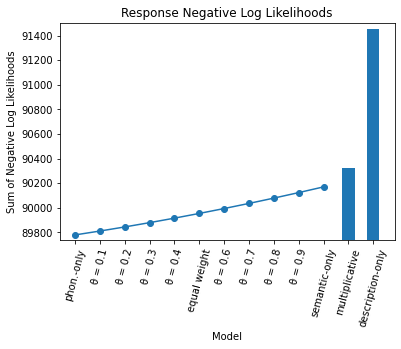

In [74]:
# plot to visualize model differences in NLL 
x = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2]
y = rgroup['NLL'] 

# x-axis tick labels
values = ['phon.-only', 'θ = 0.1', 'θ = 0.2', 'θ = 0.3','θ = 0.4','equal weight', 'θ = 0.6', 'θ = 0.7', 'θ = 0.8', 'θ = 0.9', 'semantic-only', 'multiplicative', 'description-only'] 

plt.plot(x[:11],y[:1.0],marker="o") # plot additive models (thetas 0-1) as line plot
plt.bar(x[11:],y[1.1:], width=.05) # plot other models as bar chart
plt.ylim(min(y)-45, max(y)+45) # set y-axis limits
plt.xlabel("Model")
plt.ylabel("Sum of Negative Log Likelihoods")
plt.title("Response Negative Log Likelihoods")
plt.xticks(x,values, rotation=75)
plt.show()

In [75]:
# set k (number of free parameters) for each type of model for BIC calculations
rgroup.loc[ 0:1 , 'k'] = 4
rgroup.loc[1.1 , 'k'] = 3
rgroup.loc[1.2 , 'k'] = 1

In [76]:
# create BIC column
rgroup["BIC"] = (rgroup["k"]*math.log(9849)) - (-2*rgroup['NLL']) 

In [77]:
# models sorted from lowest to highest BIC (best to worst performance)
rgroup.sort_values(by='BIC')

,NLL,k,BIC
theta,,,
0.0,89779.239403,4.0,179595.259306
0.1,89810.805550,4.0,179658.391601
0.2,89844.060531,4.0,179724.901562
0.3,89878.993327,4.0,179794.767155
0.4,89915.593074,4.0,179867.966649
0.5,89953.849058,4.0,179944.478616
0.6,89993.750711,4.0,180024.281922
0.7,90035.287612,4.0,180107.355724
0.8,90078.449482,4.0,180193.679464


In [ ]:
rgroup.to_csv("ResponseBIC.csv")


# delta BIC function

A function to create a dataframe of BICs and the difference in BIC from next worst model

In [79]:
# takes in groupdf, a dataframe of the summed NLL grouped by theta, and n, the number of responses analyzed per model
# returns the dataframe with columns k (# of params. in model), BIC, and deltaBIC (difference between model's BIC and the next highest BIC), sorted by BIC
def delta(groupdf, n):
  groupdf.loc[ 0 , 'k'] = 2
  groupdf.loc[ 0.1:0.9 , 'k'] = 4
  groupdf.loc[ 1.0 , 'k'] = 2
  groupdf.loc[1.1 , 'k'] = 3
  groupdf.loc[1.2 , 'k'] = 1 
  groupdf['BIC'] = (groupdf['k']*math.log(n)) - (-2*groupdf['NLL'])
  groupdf.sort_values(by='BIC', inplace=True)
  groupdf['deltaBIC'] = groupdf.shift(-1)['BIC'] - groupdf['BIC']
  groupdf['deltaBIC'].fillna(0, inplace=True)
  return groupdf

# Prime-based performance

First, we merge response log-likelihood data with other relevant columns from raw experimental data (skip to 5th cell to read in already merged data)

In [80]:
# response log-likelihood dataframe
respLL = pd.read_csv("ResponseLogLikelihoods.csv")

In [81]:
# merge NewAccuracy (whether or not response was correct) and prime condition from julie_files
respLL.drop(columns='Unnamed: 0', inplace=True)
respLL.rename(columns = {'resp':'Resp', 'prime': 'ActualPrime'}, inplace=True)
julie_files['ActualPrime'] = np.where(julie_files['PrimeCondition'] == 'P', julie_files['Phonological'], 
                                      np.where(julie_files['PrimeCondition'] == 'B', julie_files['Both'], 
                                               np.where(julie_files['PrimeCondition'] == 'R', julie_files['Semantic'],julie_files['Neither']))) 
julie_files['prompt'] = julie_files['prompt'].str.replace('\t',' ')                                      
julie_files['prompt'] = julie_files['prompt'].str.strip()



In [82]:
newd = respLL.merge(julie_files[['Subject', 'AgeGroup', 'ExperimentName','prompt', 'PrimeCondition', 'ActualPrime','Target', 'Resp', 'NewAccuracy', 'Question.RESP']])

In [83]:
newd.drop_duplicates(inplace=True)
newd.to_csv("ResponseLLwithGroups.csv") # saving merged dataframe

In [ ]:
# read in merged data
newd = pd.read_csv("ResponseLLwithGroups.csv")

In [84]:
# filter by prime condition
phon = newd[newd['PrimeCondition']=='P']
sem = newd[newd['PrimeCondition']=='R']
both = newd[newd['PrimeCondition']=='B']
neither = newd[newd['PrimeCondition']=='U']
print(len(phon))
print(len(sem))
print(len(both))
print(len(neither))

33592
32955
32877
28613


In [85]:
# group by model, sum negative log-likelihoods
phong = phon[['theta', 'NLL']].groupby(['theta']).sum()
semg = sem[['theta', 'NLL']].groupby(['theta']).sum()
bothg = both[['theta', 'NLL']].groupby(['theta']).sum()
neitherg = neither[['theta', 'NLL']].groupby(['theta']).sum()

Next, we plot & get tables for response negative log-likelihoods for each prime condition

## Phonological

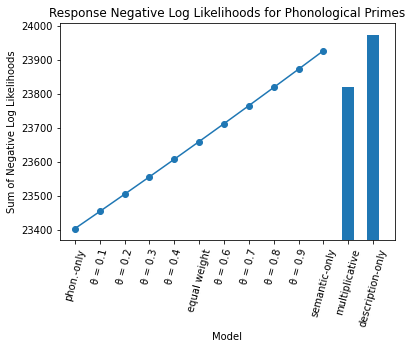

In [86]:
x = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2] # models
y = phong['NLL']

values = ['phon.-only', 'θ = 0.1', 'θ = 0.2', 'θ = 0.3','θ = 0.4','equal weight', 'θ = 0.6', 'θ = 0.7', 'θ = 0.8', 'θ = 0.9', 'semantic-only', 'multiplicative', 'description-only'] 

plt.plot(x[:11],y[:1.0],marker="o")
plt.bar(x[11:],y[1.1:], width=.05)
plt.ylim(min(y)-35, max(y)+35)
plt.xlabel("Model")
plt.ylabel("Sum of Negative Log Likelihoods")
plt.title("Response Negative Log Likelihoods for Phonological Primes")
plt.xticks(x,values, rotation=75)
plt.show()

In [87]:
# calculate and sort BICs
delta(phong, len(phon)/13)

,NLL,k,BIC,deltaBIC
theta,,,,
0.0,23402.988571,2.0,46821.691330,116.647159
0.1,23453.455056,4.0,46938.338488,101.830983
0.2,23504.370548,4.0,47040.169471,102.723365
0.3,23555.732230,4.0,47142.892836,103.610187
0.4,23607.537324,4.0,47246.503024,104.491518
0.5,23659.783083,4.0,47350.994542,105.367423
0.6,23712.466795,4.0,47456.361965,106.237970
0.7,23765.585780,4.0,47562.599935,103.168465
1.1,23821.098559,3.0,47665.768401,3.934759


## Semantic

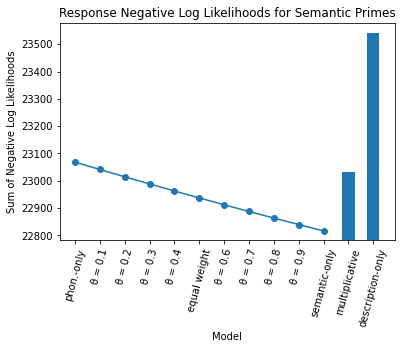

In [88]:
y = semg['NLL']

values = ['phon.-only', 'θ = 0.1', 'θ = 0.2', 'θ = 0.3','θ = 0.4','equal weight', 'θ = 0.6', 'θ = 0.7', 'θ = 0.8', 'θ = 0.9', 'semantic-only', 'multiplicative', 'description-only'] 

plt.plot(x[:11],y[:1.0],marker="o")
plt.bar(x[11:],y[1.1:], width=.05)
plt.ylim(min(y)-35, max(y)+35)
plt.xlabel("Model")
plt.ylabel("Sum of Negative Log Likelihoods")
plt.title("Response Negative Log Likelihoods for Semantic Primes")
plt.xticks(x,values, rotation=75)
plt.show()

In [89]:
delta(semg, len(sem)/13)

,NLL,k,BIC,deltaBIC
theta,,,,
1.0,22816.252783,2.0,45648.181463,62.361469
0.9,22839.595568,4.0,45710.542932,47.502342
0.8,22863.346739,4.0,45758.045274,48.323794
0.7,22887.508636,4.0,45806.369068,49.149991
0.6,22912.083632,4.0,45855.519059,49.981000
0.5,22937.074132,4.0,45905.500059,50.816886
0.4,22962.482575,4.0,45956.316946,51.657718
0.3,22988.311434,4.0,46007.974663,52.503562
0.2,23014.563215,4.0,46060.478225,23.957298


## Both

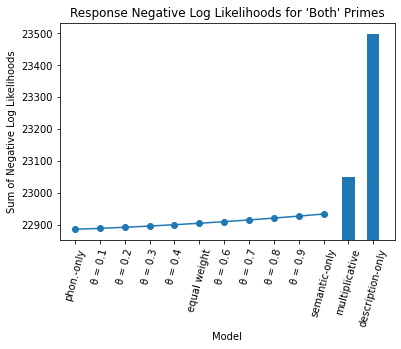

In [90]:
y = bothg['NLL']

values = ['phon.-only', 'θ = 0.1', 'θ = 0.2', 'θ = 0.3','θ = 0.4','equal weight', 'θ = 0.6', 'θ = 0.7', 'θ = 0.8', 'θ = 0.9', 'semantic-only', 'multiplicative', 'description-only'] 

plt.plot(x[:11],y[:1.0],marker="o")
plt.bar(x[11:],y[1.1:], width=.05)
plt.ylim(min(y)-35, max(y)+35)
plt.xlabel("Model")
plt.ylabel("Sum of Negative Log Likelihoods")
plt.title("Response Negative Log Likelihoods for 'Both' Primes")
plt.xticks(x,values, rotation=75)
plt.show()

In [91]:
delta(bothg, len(both)/13)

,NLL,k,BIC,deltaBIC
theta,,,,
0.0,22886.497799,2.0,45788.666757,21.575750
0.1,22889.450095,4.0,45810.242507,6.732172
0.2,22892.816181,4.0,45816.974679,7.555230
0.3,22896.593796,4.0,45824.529909,8.373820
0.4,22900.780706,4.0,45832.903729,9.188000
0.5,22905.374706,4.0,45842.091729,9.997822
0.6,22910.373617,4.0,45852.089551,10.803342
0.7,22915.775288,4.0,45862.892893,11.604612
0.8,22921.577594,4.0,45874.497505,9.925141


## Neither

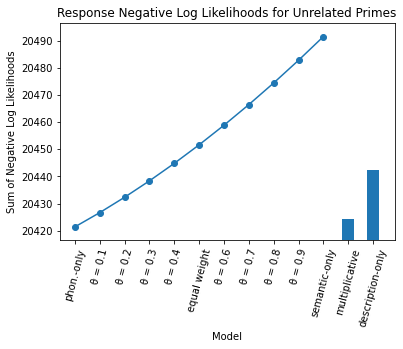

In [92]:
y = neitherg['NLL']

values = ['phon.-only', 'θ = 0.1', 'θ = 0.2', 'θ = 0.3','θ = 0.4','equal weight', 'θ = 0.6', 'θ = 0.7', 'θ = 0.8', 'θ = 0.9', 'semantic-only', 'multiplicative', 'description-only'] 

plt.plot(x[:11],y[:1.0],marker="o")
plt.bar(x[11:],y[1.1:], width=.05)
plt.ylim(min(y)-5, max(y)+5)
plt.xlabel("Model")
plt.ylabel("Sum of Negative Log Likelihoods")
plt.title("Response Negative Log Likelihoods for Unrelated Primes")
plt.xticks(x,values, rotation=75)
plt.show()

In [93]:
delta(neitherg, len(neither)/13)

,NLL,k,BIC,deltaBIC
theta,,,,
0.0,20421.407290,2.0,40858.207915,13.124815
1.1,20424.121364,3.0,40871.332730,12.773817
0.1,20426.659939,4.0,40884.106547,7.965800
1.2,20442.187840,1.0,40892.072347,3.335494
0.2,20432.310587,4.0,40895.407842,12.090560
0.3,20438.355867,4.0,40907.498402,12.873204
0.4,20444.792469,4.0,40920.371606,13.649336
0.5,20451.617137,4.0,40934.020942,14.419061
0.6,20458.826667,4.0,40948.440003,15.182481


# Correct and incorrect responses

In [ ]:
# merged dataframe
newd = pd.read_csv("ResponseLLwithGroups.csv")

In [94]:
# filter by correct and incorrect responses
incorrect = newd[newd['NewAccuracy']==0] # incorrect responses
correct = newd[newd['NewAccuracy']==1] # correct responses
print(len(incorrect))
print(len(correct))

71942
56095


In [95]:
# group by model, sum negative log-likelihoods
incorrg = incorrect[['theta', 'NLL']].groupby(['theta']).sum()
corrg = correct[['theta', 'NLL']].groupby(['theta']).sum()

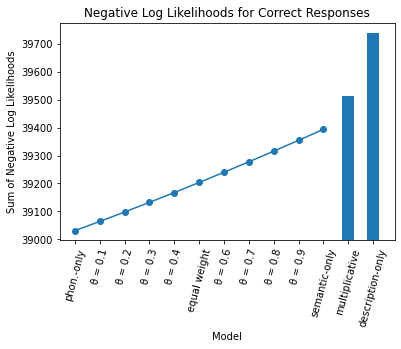

In [96]:
# plot negative log-likelihoods for correct responses
y = corrg['NLL']

values = ['phon.-only', 'θ = 0.1', 'θ = 0.2', 'θ = 0.3','θ = 0.4','equal weight', 'θ = 0.6', 'θ = 0.7', 'θ = 0.8', 'θ = 0.9', 'semantic-only', 'multiplicative', 'description-only'] 

plt.plot(x[:11], y[:1.0] ,marker="o")
plt.bar(x[11:],y[1.1:], width=.05)
plt.ylim(min(y)-35, max(y)+35)
plt.xlabel("Model")
plt.ylabel("Sum of Negative Log Likelihoods")
plt.title("Negative Log Likelihoods for Correct Responses")
plt.xticks(x,values, rotation=75)
plt.show()

In [97]:
# calculate and sort BICs
delta(corrg, len(correct)/13)

,NLL,k,BIC,deltaBIC
theta,,,,
0.0,39031.479206,2.0,78079.698117,82.661247
0.1,39064.439977,4.0,78162.359364,67.390917
0.2,39098.135435,4.0,78229.750281,68.850145
0.3,39132.560508,4.0,78298.600426,70.299359
0.4,39167.710187,4.0,78368.899785,71.738689
0.5,39203.579532,4.0,78440.638474,73.168263
0.6,39240.163663,4.0,78513.806737,74.588206
0.7,39277.457766,4.0,78588.394943,75.998643
0.8,39315.457088,4.0,78664.393585,77.399694


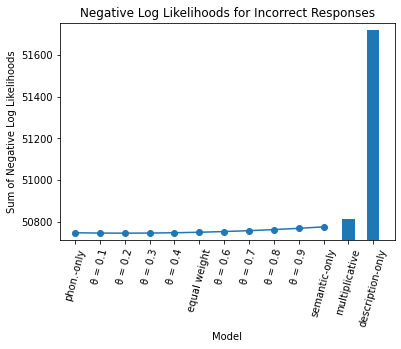

In [98]:
# plot negative log-likelihoods for incorrect responses
x = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2]
y = incorrg['NLL']

values = ['phon.-only', 'θ = 0.1', 'θ = 0.2', 'θ = 0.3','θ = 0.4','equal weight', 'θ = 0.6', 'θ = 0.7', 'θ = 0.8', 'θ = 0.9', 'semantic-only', 'multiplicative', 'description-only'] 

plt.plot(x[:11],y[:1.0],marker="o")
plt.bar(x[11:],y[1.1:], width=.05)
plt.ylim(min(y)-35, max(y)+35)
plt.xlabel("Model")
plt.ylabel("Sum of Negative Log Likelihoods")
plt.title("Negative Log Likelihoods for Incorrect Responses")
plt.xticks(x,values, rotation=75)
plt.show()

In [99]:
# calculate and sort BICs
delta(incorrg, len(incorrect)/13)

,NLL,k,BIC,deltaBIC
theta,,,,
0.0,50747.760196,2.0,101512.757725,13.567130
0.2,50745.925095,4.0,101526.324855,0.880955
0.1,50746.365573,4.0,101527.205810,0.134493
0.3,50746.432819,4.0,101527.340303,2.900135
0.4,50747.882887,4.0,101530.240439,4.773278
0.5,50750.269526,4.0,101535.013717,6.635043
0.6,50753.587048,4.0,101541.648760,8.485596
0.7,50757.829845,4.0,101550.134356,10.325097
0.8,50762.992394,4.0,101560.459453,8.887960


# Retrieval State

In [100]:
# filter by response to question about cognitive state
know = newd[newd['Question.RESP'] == 1] # "I know the answer"
dontknow = newd[newd['Question.RESP'] == 2] # "I don't know the answer"
otherword = newd[newd['Question.RESP'] == 3] # "I have another word in mind that I don't think is correct"
tot = newd[newd['Question.RESP'] == 4] # "The correct answer is on the tip of my tongue"
print(len(know))
print(len(dontknow))
print(len(otherword))
print(len(tot))

89479
3354
27716
7488


In [101]:
# group by model and sum negative log-likelihoods
knowg = know[['theta', 'NLL']].groupby(['theta']).sum()
dontknowg = dontknow[['theta', 'NLL']].groupby(['theta']).sum()
otherwordg = otherword[['theta', 'NLL']].groupby(['theta']).sum()
totg = tot[['theta', 'NLL']].groupby(['theta']).sum()

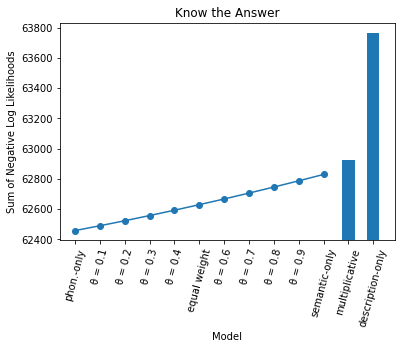

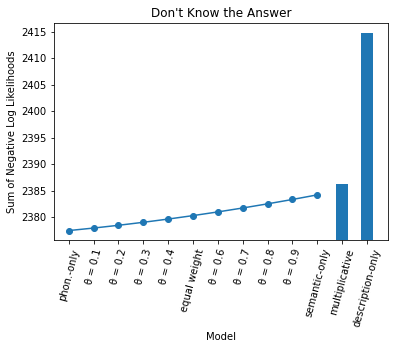

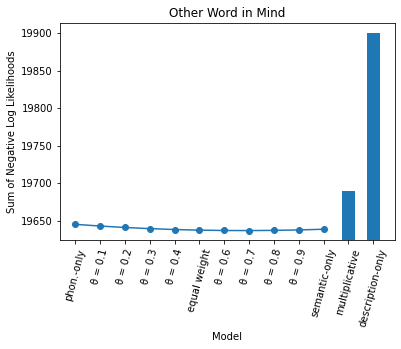

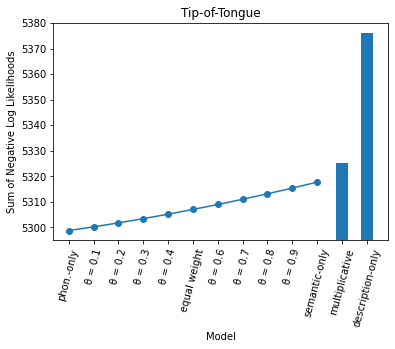

In [102]:
# plots for each state
states = {"Know the Answer": knowg, "Don't Know the Answer": dontknowg, "Other Word in Mind": otherwordg, "Tip-of-Tongue": totg}
for state in states.keys():
  y = states[state]['NLL']
  k = (max(y) - min(y)) / 20
  plt.plot(x[:11],y[:1.0],marker="o")
  plt.bar(x[11:],y[1.1:], width=.05)
  plt.ylim(min(y)-k, max(y)+k)
  plt.xlabel("Model")
  plt.ylabel("Sum of Negative Log Likelihoods")
  plt.title(state)
  plt.xticks(x,values, rotation=75)
  plt.show()

In [103]:
# results sorted from lowest (best) to highest
s1 = delta(knowg, len(know)/13)

In [104]:
s1

,NLL,k,BIC,deltaBIC
theta,,,,
0.0,62458.002321,2.0,124933.678262,81.506748
0.1,62489.918885,4.0,125015.185010,66.186735
0.2,62523.012253,4.0,125081.371745,68.524822
0.3,62557.274664,4.0,125149.896567,70.847599
0.4,62592.698463,4.0,125220.744166,73.155273
0.5,62629.276100,4.0,125293.899440,75.448049
0.6,62667.000125,4.0,125369.347489,77.726126
0.7,62705.863188,4.0,125447.073615,79.989702
0.8,62745.858039,4.0,125527.063317,82.238971


In [105]:
# average BIC of additive models, repeated for each retrieval state
np.mean(s1['BIC'][0.1:0.9]) 

125301.54262613894

In [106]:
s2 = delta(dontknowg, len(dontknow)/13)
s2.sort_values(by='theta',inplace=True)
np.mean(s2['BIC'][0.1:0.9]) 

4783.053053684042

In [108]:
s3 = delta(otherwordg, len(otherword)/13)
s3.sort_values(by='theta',inplace=True)
np.mean(s3['BIC'][0.1:0.9])

39307.566236975625

In [112]:
delta(otherwordg, len(otherword)/13)

,NLL,k,BIC,deltaBIC
theta,,,,
1.0,19638.469038,2.0,39292.267707,11.756306
0.7,19636.682375,4.0,39304.024012,0.219838
0.6,19636.792294,4.0,39304.243851,0.268606
0.8,19636.926597,4.0,39304.512457,0.663808
0.5,19637.258501,4.0,39305.176265,0.175875
0.0,19645.011254,2.0,39305.352140,0.352815
0.9,19637.522846,4.0,39305.704955,1.120657
0.4,19638.083175,4.0,39306.825612,2.370702
0.3,19639.268526,4.0,39309.196315,3.096545


In [110]:
s4 = delta(totg, len(tot)/13)
s4.sort_values(by='theta',inplace=True)
np.mean(s4['BIC'][0.1:0.9])

10640.150971763393

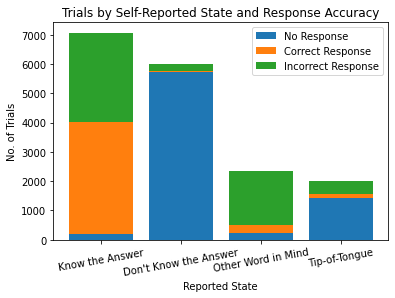

In [ ]:
# plot the proportion of trials in each state that were incorrect, correct or didn't respond 

st = states.keys()

# count the number of no-responses, correct, and incorrect responses for each state 
noresp = [len(julie_files[(julie_files['Resp'] == '12345')&(julie_files['Question.RESP'] == s)]) for s in range(1,5)]
corr = [len(julie_files[(julie_files['NewAccuracy'] == 1)&(julie_files['Question.RESP'] == s)]) for s in range(1,5)]
incorr = [len(julie_files[(julie_files['Resp'] != '12345')&(julie_files['NewAccuracy'] == 0)&(julie_files['Question.RESP'] == s)]) for s in range(1,5)]


# plot a bar for each state and corresponding number, set the bottom of each category to the height of the previous one
plt.bar(st, noresp)
plt.bar(st, corr, bottom = np.array(noresp))
plt.bar(st, incorr, bottom = np.array(noresp) + np.array(corr))


plt.xlabel("Reported State")
plt.xticks(rotation = 10)
plt.ylabel("No. of Trials")
plt.title('Trials by Self-Reported State and Response Accuracy')
plt.legend(["No Response", "Correct Response", "Incorrect Response"])

plt.show()


# By prime condition and retrieval state


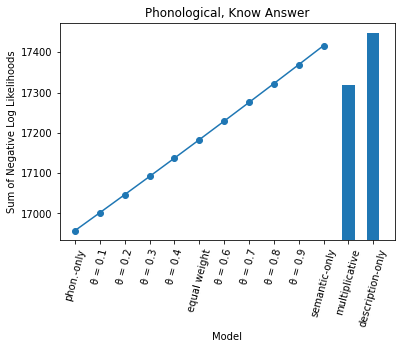

                NLL    k           BIC    deltaBIC
theta                                             
0.0    16957.235657  2.0  33929.554680  104.051582
0.1    17001.719765  4.0  34033.606262   89.623898
0.2    17046.531714  4.0  34123.230160   90.275435
0.3    17091.669431  4.0  34213.505595   90.922876
0.4    17137.130870  4.0  34304.428472   91.566272
0.5    17182.914006  4.0  34395.994744   92.205670
0.6    17229.016841  4.0  34488.200414   92.841120
0.7    17275.437401  4.0  34581.041534   80.523454
1.1    17319.469969  3.0  34661.564987   12.949214
0.8    17322.173734  4.0  34674.514201   94.100360
0.9    17369.223914  4.0  34768.614561   79.640878
1.0    17416.586036  2.0  34848.255439   55.591668
1.2    17448.152712  1.0  34903.847107    0.000000


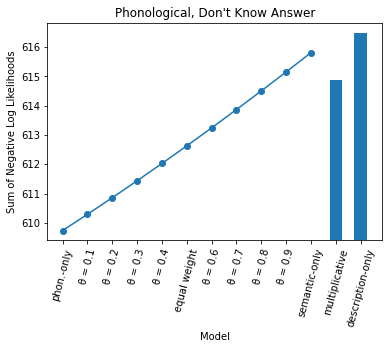

              NLL    k          BIC  deltaBIC
theta                                        
0.0    609.734711  2.0  1227.848732  9.311944
1.2    616.485510  1.0  1237.160676  0.177179
0.1    610.289618  4.0  1237.337855  1.133695
0.2    610.856466  4.0  1238.471550  1.157422
0.3    611.435177  4.0  1239.628972  0.374386
1.0    615.812024  2.0  1240.003358  0.806609
0.4    612.025674  4.0  1240.809968  1.204418
0.5    612.627883  4.0  1242.014386  0.299377
1.1    614.872399  3.0  1242.313762  0.928315
0.6    613.241729  4.0  1243.242077  1.250818
0.7    613.867138  4.0  1244.492895  1.273800
0.8    614.504038  4.0  1245.766695  1.296638
0.9    615.152357  4.0  1247.063333  0.000000


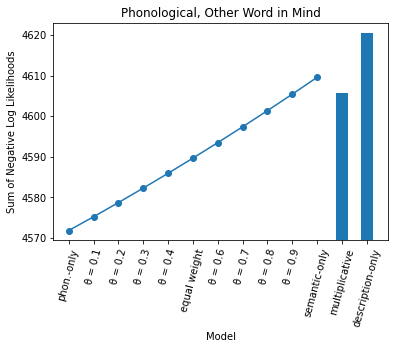

               NLL    k          BIC   deltaBIC
theta                                          
0.0    4571.800730  2.0  9156.010575  19.218475
0.1    4575.205410  4.0  9175.229051   6.978658
0.2    4578.694739  4.0  9182.207709   7.146927
0.3    4582.268202  4.0  9189.354636   7.314181
0.4    4585.925293  4.0  9196.668816   7.480433
0.5    4589.665509  4.0  9204.149249   7.645695
0.6    4593.488357  4.0  9211.794944   7.809982
0.7    4597.393347  4.0  9219.604926   7.973305
0.8    4601.380000  4.0  9227.578231   2.687207
1.1    4605.825882  3.0  9230.265438   1.336468
1.0    4609.596395  2.0  9231.601905   4.112003
0.9    4605.447839  4.0  9235.713909  11.609755
1.2    4620.559553  1.0  9247.323663   0.000000


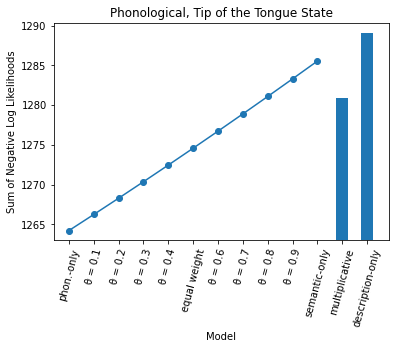

               NLL    k          BIC   deltaBIC
theta                                          
0.0    1264.217473  2.0  2538.289453  13.900089
0.1    1266.240264  4.0  2552.189542   4.094731
0.2    1268.287630  4.0  2556.284274   4.143581
0.3    1270.359420  4.0  2560.427855   4.192135
0.4    1272.455488  4.0  2564.619990   4.240395
0.5    1274.575685  4.0  2568.860385   4.288366
0.6    1276.719868  4.0  2573.148751   3.493628
1.1    1280.930309  3.0  2576.642380   0.842422
0.7    1278.887894  4.0  2577.484802   3.436940
1.0    1285.533618  2.0  2580.921742   0.946512
0.8    1281.079620  4.0  2581.868255   1.214357
1.2    1289.077679  1.0  2583.082611   3.216218
0.9    1283.294907  4.0  2586.298829   0.000000


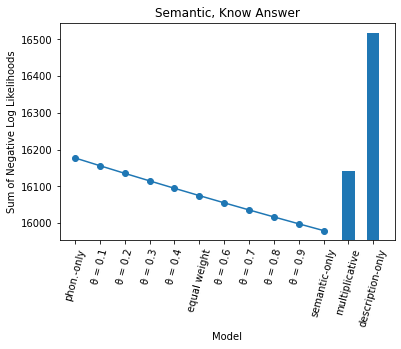

                NLL    k           BIC    deltaBIC
theta                                             
1.0    15980.113367  2.0  31975.197717   51.875964
0.9    15998.565857  4.0  32027.073681   37.472215
0.8    16017.301965  4.0  32064.545896   38.042798
0.7    16036.323364  4.0  32102.588694   38.616777
0.6    16055.631752  4.0  32141.205470   39.194197
0.5    16075.228850  4.0  32180.399667   39.775106
0.4    16095.116404  4.0  32220.174774   40.359552
0.3    16115.296180  4.0  32260.534326   40.947583
0.2    16135.769971  4.0  32301.481909    7.383696
1.1    16143.204565  3.0  32308.865605   34.155551
0.1    16156.539595  4.0  32343.021156   27.163611
0.0    16177.606892  2.0  32370.184767  672.714957
1.2    16517.707116  1.0  33042.899724    0.000000


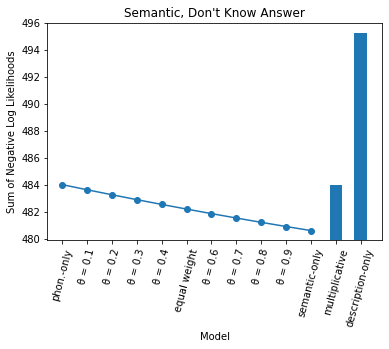

              NLL    k         BIC   deltaBIC
theta                                        
1.0    480.602302  2.0  969.145187   6.815539
0.0    484.010071  2.0  975.960726   1.728851
0.9    480.904205  4.0  977.689577   0.620803
0.8    481.214606  4.0  978.310381   0.637902
0.7    481.533558  4.0  978.948283   0.655106
0.6    481.861110  4.0  979.603389   0.341796
1.1    484.017154  3.0  979.945184   0.330619
0.5    482.197318  4.0  980.275803   0.689831
0.4    482.542233  4.0  980.965634   0.707355
0.3    482.895911  4.0  981.672989   0.724990
0.2    483.258406  4.0  982.397979   0.742736
0.1    483.629774  4.0  983.140715  11.386652
1.2    495.278538  1.0  994.527367   0.000000


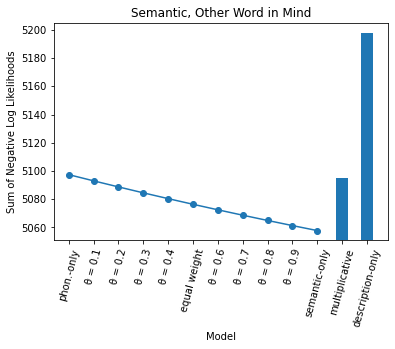

               NLL    k           BIC    deltaBIC
theta                                            
1.0    5057.742302  2.0  10128.129734   19.723373
0.9    5061.281423  4.0  10147.853108    7.263788
0.8    5064.913317  4.0  10155.116896    7.450298
0.7    5068.638466  4.0  10162.567194    7.637786
0.6    5072.457360  4.0  10170.204980    7.826268
0.5    5076.370493  4.0  10178.031248    8.015755
0.4    5080.378371  4.0  10186.047003    8.206264
0.3    5084.481503  4.0  10194.253267    8.397808
0.2    5088.680407  4.0  10202.651075    4.729334
0.0    5097.367639  2.0  10207.380409    1.086368
1.1    5094.749541  3.0  10208.466777    2.774701
0.1    5092.975609  4.0  10211.241478  190.750806
1.2    5197.834860  1.0  10401.992284    0.000000


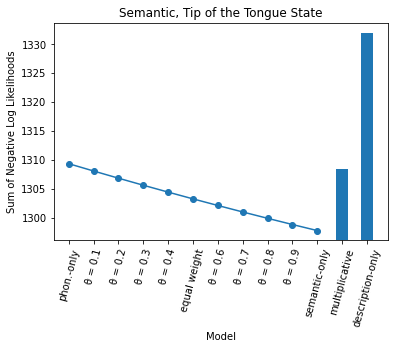

               NLL    k          BIC   deltaBIC
theta                                          
1.0    1297.794812  2.0  2605.515314  12.024230
0.9    1298.844083  4.0  2617.539544   2.145536
0.8    1299.916851  4.0  2619.685080   2.192796
0.7    1301.013249  4.0  2621.877876   2.240322
0.6    1302.133410  4.0  2624.118198   2.288121
0.5    1303.277470  4.0  2626.406319   2.241649
0.0    1309.361139  2.0  2628.647968   0.094545
0.4    1304.445567  4.0  2628.742513   2.384546
0.3    1305.637840  4.0  2631.127059   0.740631
1.1    1308.489578  3.0  2631.867690   1.692550
0.2    1306.854431  4.0  2633.560240   2.482103
0.1    1308.095482  4.0  2636.042343  32.897640
1.2    1331.988569  1.0  2668.939983   0.000000


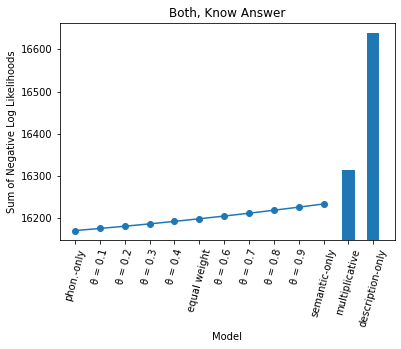

                NLL    k           BIC    deltaBIC
theta                                             
0.0    16170.921455  2.0  32356.828431   24.968430
0.1    16175.912910  4.0  32381.796861   10.571794
0.2    16181.198807  4.0  32392.368655   11.157330
0.3    16186.777472  4.0  32403.525985   11.739558
0.4    16192.647251  4.0  32415.265543   12.318519
0.5    16198.806511  4.0  32427.584063   12.894252
0.6    16205.253637  4.0  32440.478314   13.466795
0.7    16211.987034  4.0  32453.945109   14.036186
0.8    16219.005127  4.0  32467.981295   14.602465
0.9    16226.306360  4.0  32482.583760    0.180147
1.0    16233.889194  2.0  32482.763908  168.892025
1.1    16314.588826  3.0  32651.655933  633.276738
1.2    16638.719955  1.0  33284.932671    0.000000


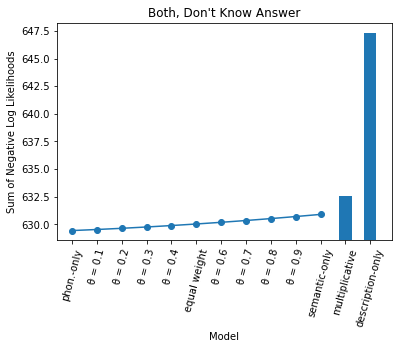

              NLL    k          BIC   deltaBIC
theta                                         
0.0    629.436556  2.0  1267.341326   2.926584
1.0    630.899849  2.0  1270.267910   5.735458
0.1    629.533471  4.0  1276.003369   0.216120
0.2    629.641531  4.0  1276.219489   0.238284
0.3    629.760673  4.0  1276.457772   0.260323
0.4    629.890835  4.0  1276.718095   0.282240
0.5    630.031955  4.0  1277.000336   0.304037
0.6    630.183973  4.0  1277.304372   0.325714
0.7    630.346830  4.0  1277.630086   0.178034
1.1    632.552900  3.0  1277.808120   0.169239
0.8    630.520467  4.0  1277.977360   0.368717
0.9    630.704825  4.0  1278.346077  20.531382
1.2    647.321676  1.0  1298.877459   0.000000


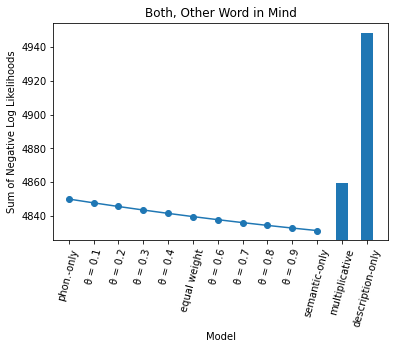

               NLL    k          BIC    deltaBIC
theta                                           
1.0    4831.410386  2.0  9675.366527   15.520500
0.9    4832.897760  4.0  9690.887027    3.141251
0.8    4834.468385  4.0  9694.028279    3.308517
0.7    4836.122644  4.0  9697.336796    3.476554
0.6    4837.860921  4.0  9700.813350    3.645374
0.5    4839.683608  4.0  9704.458724    3.814986
0.4    4841.591101  4.0  9708.273710    3.985404
0.3    4843.583803  4.0  9712.259114    0.441174
0.0    4850.077267  2.0  9712.700288    3.715462
0.2    4845.662121  4.0  9716.415750    4.328697
0.1    4847.826469  4.0  9720.744447   17.282736
1.1    4859.604276  3.0  9738.027182  165.069734
1.2    4948.412020  1.0  9903.096916    0.000000


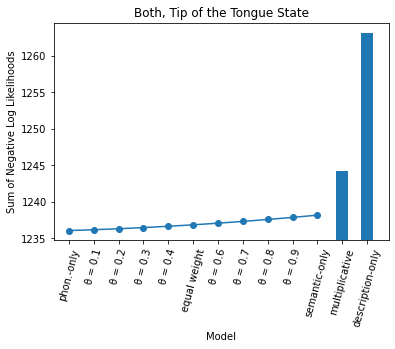

               NLL    k          BIC   deltaBIC
theta                                          
0.0    1236.062521  2.0  2481.935591   4.227589
1.0    1238.176315  2.0  2486.163180   5.812408
0.1    1236.177244  4.0  2491.975588   0.272955
0.2    1236.313722  4.0  2492.248543   0.316253
0.3    1236.471848  4.0  2492.564796   0.359342
0.4    1236.651519  4.0  2492.924138   0.402226
0.5    1236.852633  4.0  2493.326364   0.444907
0.6    1237.075086  4.0  2493.771272   0.487388
0.7    1237.318780  4.0  2494.258659   0.529669
0.8    1237.583615  4.0  2494.788328   0.571755
0.9    1237.869492  4.0  2495.360083   7.849938
1.1    1244.247098  3.0  2503.210021  28.044458
1.2    1263.174602  1.0  2531.254479   0.000000


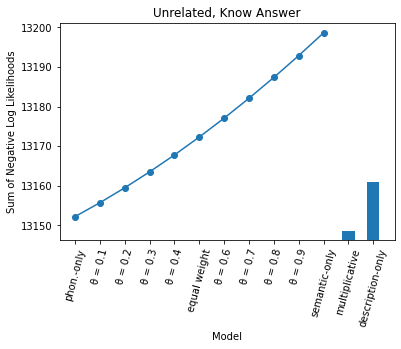

                NLL    k           BIC   deltaBIC
theta                                            
0.0    13152.238317  2.0  26318.994867   0.200523
1.1    13148.709021  3.0  26319.195390   9.958715
1.2    13160.947494  1.0  26329.154105  11.375591
0.1    13155.746616  4.0  26340.529696   7.530290
0.2    13159.511761  4.0  26348.059986   8.039640
0.3    13163.531581  4.0  26356.099626   8.544716
0.4    13167.803939  4.0  26364.644343   9.045589
0.5    13172.326733  4.0  26373.689931   9.542324
0.6    13177.097895  4.0  26383.232255  10.034988
0.7    13182.115389  4.0  26393.267243  10.523646
0.8    13187.377212  4.0  26403.790889   7.979321
1.0    13198.625989  2.0  26411.770210   3.029039
0.9    13192.881393  4.0  26414.799250   0.000000


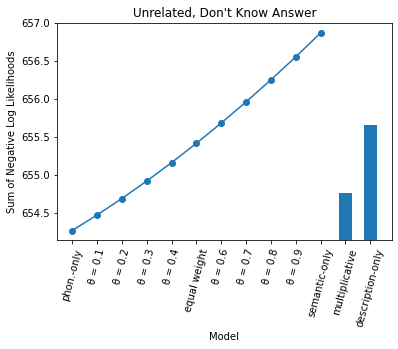

              NLL    k          BIC  deltaBIC
theta                                        
1.2    655.658728  1.0  1315.565951  1.471553
0.0    654.270257  2.0  1317.037505  5.203047
1.0    656.871780  2.0  1322.240551  0.047431
1.1    654.771248  3.0  1322.287983  3.655917
0.1    654.474959  4.0  1325.943900  0.434597
0.2    654.692258  4.0  1326.378497  0.459579
0.3    654.922047  4.0  1326.838076  0.484352
0.4    655.164223  4.0  1327.322428  0.508921
0.5    655.418684  4.0  1327.831349  0.533288
0.6    655.685328  4.0  1328.364638  0.557457
0.7    655.964057  4.0  1328.922095  0.581431
0.8    656.254772  4.0  1329.503526  0.605212
0.9    656.557379  4.0  1330.108738  0.000000


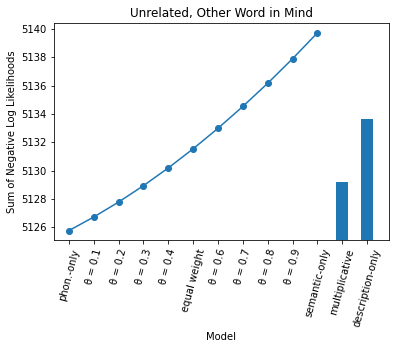

               NLL    k           BIC  deltaBIC
theta                                          
0.0    5125.765618  2.0  10264.151072  9.459003
1.2    5133.650079  1.0  10273.610076  3.708068
1.1    5129.194195  3.0  10277.318144  1.367095
0.1    5126.722783  4.0  10278.685239  2.113497
0.2    5127.779532  4.0  10280.798736  2.310972
0.3    5128.935018  4.0  10283.109708  2.506785
0.4    5130.188410  4.0  10285.616493  2.700962
0.5    5131.538891  4.0  10288.317455  2.893532
0.6    5132.985657  4.0  10291.210987  0.848758
1.0    5139.719954  2.0  10292.059745  2.235762
0.7    5134.527917  4.0  10294.295507  3.273955
0.8    5136.164894  4.0  10297.569462  3.461860
0.9    5137.895824  4.0  10301.031322  0.000000


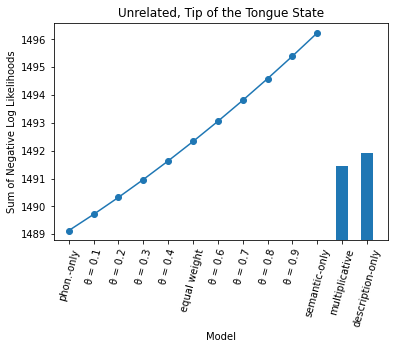

               NLL    k          BIC  deltaBIC
theta                                         
0.0    1489.133098  2.0  2988.416544  0.521708
1.2    1491.931539  1.0  2988.938252  9.181071
1.1    1491.446901  3.0  2998.119323  1.612535
0.1    1489.715581  4.0  2999.731858  1.222910
0.2    1490.327036  4.0  3000.954768  1.280369
0.3    1490.967221  4.0  3002.235137  0.381995
1.0    1496.233392  2.0  3002.617132  0.955356
0.4    1491.635896  4.0  3003.572488  1.393865
0.5    1492.332829  4.0  3004.966353  1.449916
0.6    1493.057787  4.0  3006.416269  1.505514
0.7    1493.810544  4.0  3007.921783  1.560665
0.8    1494.590877  4.0  3009.482449  1.615376
0.9    1495.398565  4.0  3011.097825  0.000000


In [111]:
# plots and tables for each prime condition and state
x = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2]
values = ['phon.-only', 'θ = 0.1', 'θ = 0.2', 'θ = 0.3','θ = 0.4','equal weight', 'θ = 0.6', 'θ = 0.7', 'θ = 0.8', 'θ = 0.9', 'semantic-only', 'multiplicative', 'description-only'] 
pc = {'P': 'Phonological', 'R': 'Semantic', 'B': 'Both', 'U': 'Unrelated'}
states = ["Know Answer", "Don't Know Answer", "Other Word in Mind", "Tip of the Tongue State"]
for p in ['P', 'R', 'B', 'U']:
  for i in range(1,5):
    subset = newd[(newd['PrimeCondition'] == p) & (newd['Question.RESP'] == i)]
    grouped = subset[['theta', 'NLL']].groupby(['theta']).sum()
    y = grouped['NLL']
    k = (max(y) - min(y)) / 20
    plt.plot(x[:11],y[:1.0],marker="o")
    plt.bar(x[11:],y[1.1:], width=.05)
    plt.ylim(min(y)-k, max(y)+k)
    plt.xlabel("Model")
    plt.ylabel("Sum of Negative Log Likelihoods")
    plt.title(pc[p] + ", "+ states[i-1])
    plt.xticks(x,values, rotation=75)
    plt.show()
    print(delta(grouped, len(subset)/13))